In [5]:
import numpy as np
import matplotlib.pyplot as plt
import vector
import pandas as pd
import lhapdf
import itertools

## General code for calculating polarization vector

In [27]:
# Tau mass
mtau = 1.77682 # GeV

def polarization_vector(tau4m, nu4m, nucleon4m, int_type: str, x=None, charm=None):
    M = nucleon4m.m
    ptau = tau4m.p
    Etau = tau4m.E
    theta = nu4m.deltaangle(tau4m)
    costheta = np.cos(theta)
    Enu = nu4m.E
    p = nucleon4m
    k = nu4m
    kprime = tau4m
    
    q = k - kprime # W boson 4-momentum
    # I might also pass this as a parameter. Though probably not, since the model assumes that it is a nucleon, not a nucleus.
    Q2 = -q**2
    assert np.all(Q2 > 0), Q2

    W2 = (p + q)**2
    assert np.all(W2 > 0), W2
    
    # If x is not passed as a parameter, calculate it from Q2, p and q. This might however result in an unphysical x > 1.
    if x is None:
        x = Q2 / (2*p.dot(q)) # Björken scaling variable
    
    if int_type == "qel":
        W1 = W1qel(x, Q2, p, q, M)
        W2 = W2qel(x, Q2, p, q, M)
        W3 = W3qel(x, Q2, p, q, M)
        W4 = W4qel(x, Q2, p, q, M)
        W5 = W5qel(x, Q2, p, q, M)
    elif int_type == "res":
        W1 = Wnres(x, Q2, p, q, M, 1)
        W2 = Wnres(x, Q2, p, q, M, 2)
        W3 = Wnres(x, Q2, p, q, M, 3)
        W4 = Wnres(x, Q2, p, q, M, 4)
        W5 = Wnres(x, Q2, p, q, M, 5)
    elif int_type == "dis":
        if charm is None:
            raise ValueError("charm parameter must be set to an array of bools of the same size as the 4-vectors")
        W1 = W1dis(x, Q2, p, q, M, charm)
        W2 = W2dis(x, Q2, p, q, M, charm)
        W3 = W3dis(x, Q2, p, q, M, charm)
        W4 = W4dis(x, Q2, p, q, M, charm)
        W5 = W5dis(x, Q2, p, q, M, charm)
    else:
        raise ValueError(f"Unsupported interaction type {int_type = }")
    
    R = (
        (Etau - ptau * costheta) / M * (W1 + mtau / (2*M**2)*W4)
        + (Etau + ptau * costheta) / (2*M) * W2
        + ((Enu + Etau) / M * (Etau - ptau * costheta) / (2*M) - mtau**2 / (2*M**2)) * W3
        - mtau**2 / (2*M) * W5
    )

    return (
        # P_P component, in the tau-nu plane
        mtau * np.sin(theta) / (2*M*R) * (
            -(2*W1 - W2 - mtau**2/M**2 * W4 + Etau/M * W5) - Enu / M * W3 # X in lepton polarization paper, eq 7a
        ),
        # P_L component
        -1 + mtau**2/(M**2 * R) * (
            (2*M/(Etau + ptau) * W1 + (Etau - ptau) / (Etau + ptau) * W3) * np.cos(theta/2)**2
            + (M/(Etau + ptau) * W2 + (Etau + ptau) / M * W4 - W5) * np.sin(theta/2)**2
        ),
    )


def spin_vector(tau4m, nu4m, nucleon4m, int_type: str, x=None, W=None, charm=None):
    M = nucleon4m.m
    ptau = tau4m.p
    Etau = tau4m.E
    theta = nu4m.deltaangle(tau4m)
    costheta = np.cos(theta)
    Enu = nu4m.E
    p = nucleon4m
    k = nu4m
    kprime = tau4m
    
    q = k - kprime # W boson 4-momentum
    Q2 = -q**2
    
    if x is None:
        print("WARNING: x is not passed as a parameter, calculating it manually")
        x = Q2 / (2*p.dot(q)) # Björken scaling variable
    if W is None:
        print("WARNING: W is not passed as a parameter, calculating it manually")
        W = (p + q)**2 # Hadronic invariant mass
    
    if int_type == "qel":
        W1 = W1qel(x, Q2, p, q, M)
        W2 = W2qel(x, Q2, p, q, M)
        W3 = W3qel(x, Q2, p, q, M)
        W4 = W4qel(x, Q2, p, q, M)
        W5 = W5qel(x, Q2, p, q, M)
    elif int_type == "res":
        W1 = Wnres(x, Q2, p, q, M, 1, W)
        W2 = Wnres(x, Q2, p, q, M, 2, W)
        W3 = Wnres(x, Q2, p, q, M, 3, W)
        W4 = Wnres(x, Q2, p, q, M, 4, W)
        W5 = Wnres(x, Q2, p, q, M, 5, W)
    elif int_type == "dis":
        if charm is None:
            raise ValueError("charm parameter must be set to an array of bools of the same size as the 4-vectors")
        W1 = W1dis(x, Q2, p, q, M, charm, W)
        W2 = W2dis(x, Q2, p, q, M, charm, W)
        W3 = W3dis(x, Q2, p, q, M, charm, W)
        W4 = W4dis(x, Q2, p, q, M, charm, W)
        W5 = W5dis(x, Q2, p, q, M, charm, W)
    else:
        raise ValueError(f"Unsupported interaction type {int_type = }")
    
    F = (
        (2*W1 + mtau**2 / M**2 * W4) * (Etau - ptau * costheta)
        + W2 * (Etau + ptau * costheta)
        + W3 / M * (Enu * Etau + ptau**2 - (Enu + Etau) * ptau * costheta)
        - mtau**2 / M * W5
    )

    return (
        # sx component, in the tau-nu plane
        -mtau*np.sin(theta)/2 *
        (2*W1 - W2 + Enu / M * W3 - mtau**2/M**2 * W4 + Etau/M * W5)
        / F,
        # sz component
        -1/2 * (
            (2*W1 - mtau**2 / M**2 * W4) * (ptau - Etau * costheta)
            + W2 * (ptau + Etau * costheta)
            + W3 / M * ((Enu + Etau) * ptau - (Enu * Etau + ptau**2) * costheta)
            - mtau**2 / M * W5 * costheta
        ) / F
    )

In [13]:
# Cabbibo angle, from https://en.wikipedia.org/wiki/Cabibbo%E2%80%93Kobayashi%E2%80%93Maskawa_matrix
theta_c = 13.02 * np.pi/180 # radians
#
M_V_qel = 0.84 # GeV
# difference between muon and electron magnetic moments (I think, see tau polarization paper)
xi_qel = 3.706
# 
M_A_qel = 1 # GeV
#
F_A_0_qel = -1.23
# Pion mass
m_pi = 0.139 # GeV


def w(p, q, M):
    return p.dot(q)/M**2 # M*q.E / M**2 = q.E / M

def G_V_E(q):
    return 1 / (1-q**2/M_V_qel**2)**2

def G_V_M(q):
    return (1+xi_qel) / (1-q**2/M_V_qel**2)**2

def F_V(q, M):
    return (G_V_E(q) - q**2 / (4*M**2) * G_V_M(q)) / (1 - q**2 / (4*M**2))

def F_M(q, M):
    return (G_V_M(q) - G_V_M(q)) / (xi_qel * (1 - q**2 / (4*M**2)))

def F_A(q):
    return F_A_0_qel / (1 - q**2 / M_A_qel**2)**2

def F_T(q):
    return 0

def F_S(q):
    return 0

def F_p(q, M):
    return 2*M**2 * F_A(q) / (m_pi**2 - q**2)

def Wqel_coefficient(p, q, M):
    return np.cos(theta_c)**2 * 1/w(p, q, M) 

def W1qel(x, Q2, p, q, M):
    xprime = Q2 / (4*M**2)
    return (
        Wqel_coefficient(p, q, M)
        * (F_A(q)**2 + xprime * (F_A(q)**2 + (F_V(q, M) + F_M(q, M))**2))
    )

def omega_2(x, Q2, p, q, M):
    xprime = Q2 / (4*M**2)
    return F_V(q, M)**2 + F_A(q)**2 + xprime * (F_M(q, M)**2 + 4*F_T(q)**2)

def W2qel(x, Q2, p, q, M):
    return (
        Wqel_coefficient(p, q, M)
        * omega_2(x, Q2, p, q, M)
    )

def W3qel(x, Q2, p, q, M):
    return (
        Wqel_coefficient(p, q, M)
        * -2 * np.real(np.conj(F_A(q)) * (F_V(q, M) + F_M(q, M)))
    )

def W4qel(x, Q2, p, q, M):
    xprime = Q2 / (4*M**2)
    return (
        Wqel_coefficient(p, q, M)
        # omega_4
        * (
            np.real(np.conj(F_V(q, M)) * (F_S(q) - 1/2 * F_M(q, M)) - np.conj(F_A(q)) * (F_T(q) + F_p(q, M)))
            + xprime * (1/2 * (F_M(q, M) - F_S(q))**2 + (F_T(q) + F_p(q, M))**2)
            - 1/4* (1+xprime) * F_M(q, M)**2 + (1+1/2 * xprime) * F_S(q)**2
        )
    )

def W5qel(x, Q2, p, q, M):
    xprime = Q2 / (4*M**2)
    return (
        Wqel_coefficient(p, q, M)
        * (
            2 * np.real(np.conj(F_S(q)) * (F_V(q, M) - xprime*F_M(q, M)) - np.conj(F_T(q)) * (F_A(q) - 2*xprime*F_p(q, M)))
            + omega_2(x, Q2, p, q, M)
        )
    )

In [65]:
particle_info = pd.read_csv("../data/test_genie_NuTau_10.0_GeV_particles.csv")
event_info = pd.read_csv("../data/test_genie_NuTau_10.0_GeV_event_info.csv")

In [66]:
qel_particles = particle_info[
    particle_info["event_num"]
    .isin(event_info.loc[event_info["qel"], "event_num"].values)
]
qel_events = event_info[event_info["qel"]]

taus = qel_particles[qel_particles["pdg"] == 15]
nus = qel_particles.groupby("event_num").nth(1)
assert np.all(nus["pdg"] == 16)
nucleons = qel_particles.groupby("event_num").first()
assert np.all(nucleons["pdg"] > 1000)
tau_angles = np.arctan(np.sqrt(taus["px"]**2 + taus["py"]**2) / taus["pz"])

In [67]:
nutaus = qel_particles.groupby("event_num").nth(1).reset_index(drop=True)
assert (nutaus["pdg"] == 16).all()
taus = qel_particles.groupby("event_num").nth(2).reset_index(drop=True)
assert (taus["pdg"] == 15).all()

nutau4m = vector.array({"E": nutaus["E"], "px": nutaus["px"], "py": nutaus["py"], "pz": nutaus["pz"]})
tau4m = vector.array({"E": taus["E"], "px": taus["px"], "py": taus["py"], "pz": taus["pz"]})
q = nutau4m - tau4m
# Sanity checks
assert ((q["E"]**2 - q["px"]**2 - q["py"]**2 - q["pz"]**2) < 0).all()
assert np.all((q**2) < 0)
    
# The nucleon mass used is the one calculated using Ws. 
# TODO is it better to use the constant mass, calculated using W? 
# For that case, the mass and W cancel each other out
M = -q.E + np.sqrt(qel_events["Ws"]**2 + q.px**2 + q.py**2 + q.pz**2)

# delta-function, where x must be 1. To get this, we adjust the mass of the nucleon
# M = -q**2 / (2*q.E)
nucleon4m = vector.array({"E": M, "px": np.zeros(M.shape), "py": np.zeros(M.shape), "pz": np.zeros(M.shape)})
# x = -q**2 / (2*nucleon4m.dot(q))
# assert np.allclose(x, 1), x

In [68]:
s = np.array(spin_vector(
    vector.MomentumNumpy4D(tau4m[zero_angle_tau_event]), 
    vector.MomentumNumpy4D(nutau4m[zero_angle_tau_event]), 
    vector.MomentumNumpy4D(nucleon4m[zero_angle_tau_event]), 
    "qel",
    x=qel_events.iloc[zero_angle_tau_event]["xs"],
    W=qel_events.iloc[zero_angle_tau_event]["Ws"]
    )
)
# The polarization (second term) should be slightly below 1 (center left panel, fig 6 in tau polarization paper)
# The polarization angle cos(theta_p) (third term) should be very close to -1 (bottom center panel, fig 6 in tau polarization paper)
s, np.linalg.norm(s)*2, s[1] / np.linalg.norm(s)

(array([[-0.00087923],
        [-0.47880989]]),
 0.9576213972800067,
 array([-0.99999831]))

The values above are really good and close to what they should be. Let us now check $\theta = 5^\circ, 10^\circ$, since these are reproduced in the paper as well.

In [69]:
almost5deg = np.abs(tau_angles * 180/np.pi - 5).argmin()
tau_angles.iloc[almost5deg] * 180/np.pi, taus.iloc[almost5deg]["E"]

(5.000498804220101, 9.420946604808174)

In [70]:
s = np.array(spin_vector(
    vector.MomentumNumpy4D(tau4m[almost5deg]), 
    vector.MomentumNumpy4D(nutau4m[almost5deg]), 
    vector.MomentumNumpy4D(nucleon4m[almost5deg]), 
    "qel",
    x=qel_events.iloc[almost5deg]["xs"],
    W=qel_events.iloc[almost5deg]["Ws"]
    )
)
# The polarization (second term) should be closer to 1 (center center panel, fig 6 in tau polarization paper)
# The polarization angle cos(theta_p) (third term) should be slightly above -1 (bottom center panel, fig 6 in tau polarization paper)
s, np.linalg.norm(s)*2, s[1] / np.linalg.norm(s)

(array([[-0.11691171],
        [-0.47870985]]),
 0.9855586555149275,
 array([-0.97144872]))

In [71]:
tau_deg = tau_angles * 180/np.pi 
# Select the event with the highest energy tau and a tau angle between 9.9 and 10.1 degrees
almost10deg = taus[((9.9 < tau_deg) & (tau_deg < 10.1)).values]["E"].idxmax()

s = np.array(spin_vector(
    vector.MomentumNumpy4D(tau4m[almost10deg]), 
    vector.MomentumNumpy4D(nutau4m[almost10deg]), 
    vector.MomentumNumpy4D(nucleon4m[almost10deg]), 
    "qel",
    x=qel_events.iloc[almost10deg]["xs"],
    W=qel_events.iloc[almost10deg]["Ws"]
    )
)
# The polarization (second term) should be closer to 1 (center center panel, fig 6 in tau polarization paper)
# The polarization angle cos(theta_p) (third term) should be slightly above -1 (bottom center panel, fig 6 in tau polarization paper)
s, np.linalg.norm(s)*2, s[1] / np.linalg.norm(s)

(array([[-0.1822185 ],
        [-0.46083747]]),
 0.9911099926131469,
 array([-0.92994213]))

### Calculate polarization for all qel events

In [50]:
s = np.array(spin_vector(
    tau4m, 
    nutau4m, 
    nucleon4m, 
    "qel",
    x=event_info["xs"].values,
    W=event_info["Ws"].values
    )
)

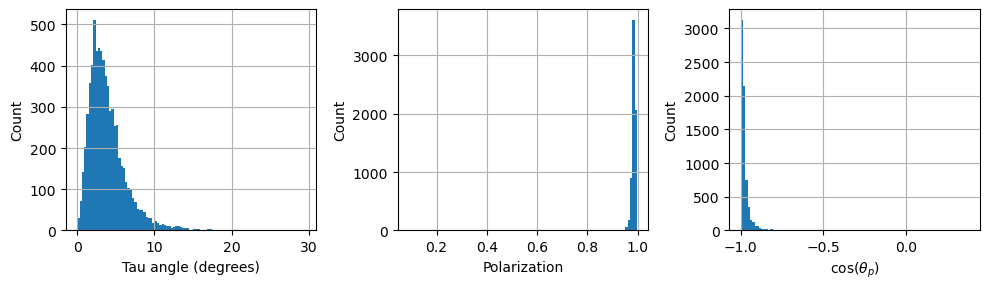

In [51]:
fig, axs = plt.subplots(ncols=3, figsize=(10, 3), layout="tight")
axs[0].hist(tau_angles * 180/np.pi, bins=100)
axs[0].set(xlabel="Tau angle (degrees)", ylabel="Count")

axs[1].hist(2*np.linalg.norm(s, axis=0), bins=100)
axs[1].set(xlabel="Polarization", ylabel="Count")

axs[2].hist(s[1] / np.linalg.norm(s, axis=0), bins=100)
axs[2].set(xlabel=r"$\cos(\theta_p)$", ylabel="Count")

for ax in axs:
    ax.grid()
    # a.set_yscale("log")

In some cases, I get a polarization vector that has magnitude > 1. Though this might not be completely incorrect, since the equations are not perfect and there might be some assumptions here and there that I break (e.g., they might always assume that the nucleon mass is 0.938 GeV, whereas that is not true and that is not the value that I pass to the code).
If $|s| > 1$, I can simply normalize the vector.

However, this is not a problem when using the spin vector equations from the tau polarization paper. Perhaps these equations are better?

## Resonance scattering

In [55]:
# Resonance scattering
# Delta mass
M_delta_res = 1.232 # GeV
# Delta width assuming dominance of S-waves
Gamma_Delta_0_res = 0.12 # GeV
# Is 2 if the Delta produced is Delta++ (interaction with p), 
# and 2/3 if the Delta produced is Delta+ (interaction with n). 
# This should not matter, as it is multiplied to all values and then divided away
kappa_res = 2/3
M_V_res = np.sqrt(0.54) # GeV
C_V_3_0_res = 2.05

C_0_res = {4: -0.3, 5: 1.2}
a_coeff_res = -1.21
b_coeff_res = 2 # GeV^2
M_A_res = 1 # GeV


def K(zeta, x, w, j, k, n):
    functions = {
        (3, 3, 3): lambda zeta, x, w: -2 * zeta**3 * (1 - 2*x)**2 * w**2 + 2 * zeta * (2 - 3*x) * w,
        (3, 3, 4): lambda zeta, x, w: -zeta**2 * (1 - 2*x)**2 * w**2 + 2 * (1 + zeta) * (1 - 2*x) * w,
        (3, 3, 5): lambda zeta, x, w: -zeta**2 * (1 - 2*x) * w + 2 * (1 + zeta),
        (3, 4, 3): lambda zeta, x, w: -zeta**2 * (1 - 2*x)**2 * w**2 + 2 * (1 - zeta) * (1 - 2*x) * w,
        (3, 4, 4): lambda zeta, x, w: zeta * (1 - 2*x)**2 * w**2,
        (3, 4, 5): lambda zeta, x, w: zeta * (1 - 2*x) * w,
        (3, 5, 3): lambda zeta, x, w: -zeta**2 * (1 - 2*x) * w**2 - 2 * (1 - zeta) * w,
        (3, 5, 4): lambda zeta, x, w: zeta * (1 - 2*x) * w**2,
        (3, 5, 5): lambda zeta, x, w: zeta * w,
    }
    if (n, j, k) not in functions:
        return 0
    
    return functions[(n, j, k)](zeta, x, w)

def A(zeta, x, w, j, k, n):
    functions = {
        (1, 3, 3): lambda zeta, x, w: zeta**3 * (1 - 2*x)**2 * w**3 + zeta * (1 + zeta**2 * (1 - 2*x)**2) * w**2 - 2 * (1 - zeta) * x * w,
        (1, 3, 4): lambda zeta, x, w: zeta**2 * (1 - 2*x)**2 * w**3 + (1 + zeta * (2 + zeta) * (1 - 2*x)) * (1 - 2*x) * w**2,
        (1, 3, 5): lambda zeta, x, w: zeta**2 * (1 - 2*x) * w**2 + (1 + zeta * (2 + zeta) * (1 - 2*x)) * w,
        (1, 4, 4): lambda zeta, x, w: zeta * (1 - 2*x)**2 * w**3 + (1 + zeta) * (1 - 2*x)**2 * w**2,
        (1, 4, 5): lambda zeta, x, w: 2 * zeta * (1 - 2*x) * w**2 + 2 * (1 + zeta) * (1 - 2*x) * w,
        (1, 5, 5): lambda zeta, x, w: zeta * w + 1 + zeta,
        (2, 3, 3): lambda zeta, x, w: 2 * zeta**3 * x * w**2 + 2 * zeta * (1 + zeta**2) * x * w,
        (2, 3, 4): lambda zeta, x, w: 2 * zeta**2 * x * w**2 + 2 * (1 + zeta)**2 * x * w,
        (2, 3, 5): lambda zeta, x, w: 2 * zeta**2 * x * w,
        (2, 4, 4): lambda zeta, x, w: 2 * zeta * x * w**2 + 2 * (1 + zeta) * x * w,
        (2, 5, 5): lambda zeta, x, w: zeta**3 * w + zeta**2 * (1 + zeta),
        (4, 3, 3): lambda zeta, x, w: 2 * zeta**3 * (1 - x) * w**2 + 2 * zeta**3 * (1 - x) * w + 1 - zeta,
        (4, 3, 4): lambda zeta, x, w: 2 * zeta**2 * (1 - x) * w**2 + (1 + 2 * zeta * (2 + zeta) * (1 - x)) * w,
        (4, 3, 5): lambda zeta, x, w: 2 * zeta**2 * w + zeta * (2 + zeta),
        (4, 3, 6): lambda zeta, x, w: -2 * zeta**2 * x * w**2 - (1 + zeta)**2 * w,
        (4, 4, 4): lambda zeta, x, w: 2 * zeta * (1 - x) * w**2 + 2 * (1 + zeta) * (1 - x) * w,
        (4, 4, 5): lambda zeta, x, w: 2 * zeta * w + 2 * (1 + zeta),
        (4, 4, 6): lambda zeta, x, w: -2 * zeta * w**2 - 2 * (1 + zeta) * w,
        (4, 5, 5): lambda zeta, x, w: zeta**3 * w + zeta**2 * (1 + zeta),
        (4, 5, 6): lambda zeta, x, w: 2 * zeta**3 * (1 - 2*x) * w**2 + 2 * zeta * (zeta * (1 + zeta) * (1 - 2*x) - 1) * w - 2 * (1 + zeta),
        (4, 6, 6): lambda zeta, x, w: zeta**3 * (1 - 2*x)**2 * w**3 + zeta * (zeta * (1 + zeta) * (1 - 2*x)**2 + 2 * x) * w**2 + 2 * (1 + zeta) * x * w,
        (5, 3, 3): lambda zeta, x, w: 2 * zeta**3 * w**2 + 2 * zeta * (1 + zeta**2) * w,
        (5, 3, 4): lambda zeta, x, w: 2 * zeta**2 * w**2 + 2 * (1 + zeta)**2 * w,
        (5, 3, 5): lambda zeta, x, w: 2 * zeta**2 * (1 + x) * w + (1 + zeta)**2,
        (5, 3, 6): lambda zeta, x, w: -4 * zeta**2 * x**2 * w**2 - 2 * (1 + zeta)**2 * x * w,
        (5, 4, 4): lambda zeta, x, w: 2 * zeta * w**2 + 2 * (1 + zeta) * w,
        (5, 4, 5): lambda zeta, x, w: 2 * zeta * w + 2 * (1 + zeta),
        (5, 4, 6): lambda zeta, x, w: -4 * zeta * x * w**2 - 4 * (1 + zeta) * x * w,
        (5, 5, 5): lambda zeta, x, w: 2 * zeta**3 * w + 2 * zeta**2 * (1 + zeta),
        (5, 5, 6): lambda zeta, x, w: 2 * zeta**3 * (1 - 2*x) * w**2 + 2 * zeta**2 * (1 + zeta) * (1 - 2*x) * w,
    }
    if (n, j, k) not in functions:
        return 0
    
    return functions[(n, j, k)](zeta, x, w)


def V(zeta, x, w, j, k, n):
    functions = {
        (1, 3, 3): lambda zeta, x, w: zeta**3 * (1 - 2*x)**2 * w**3 + zeta * (1 + zeta**2 * (1 - 2*x)**2) * w**2 + 2 * (1 + zeta) * x * w,
        (1, 3, 4): lambda zeta, x, w: zeta**2 * (1 - 2*x)**2 * w**3 + (1 - zeta * (2 - zeta) * (1 - 2*x)) * (1 - 2*x) * w**2,
        (1, 3, 5): lambda zeta, x, w: zeta**2 * (1 - 2*x) * w**3 + (1 - zeta * (2 - zeta) * (1 - 2*x)) * w**2,
        (1, 4, 4): lambda zeta, x, w: zeta * (1 - 2*x)**2 * w**3 - (1 - zeta) * (1 - 2*x)**2 * w**2,
        (1, 4, 5): lambda zeta, x, w: 2 * zeta * (1 - 2*x) * w**3 - (1 - zeta) * (1 - 4*x) * w**2,
        (1, 5, 5): lambda zeta, x, w: zeta * w**3 - (1 - zeta) * w**2,
        (2, 3, 3): lambda zeta, x, w: 2 * zeta**3 * x * w**2 + 2 * zeta * (1 + zeta**2) * x * w,
        (2, 3, 4): lambda zeta, x, w: 2 * zeta**2 * x * w**2 + 2 * (1 - zeta)**2 * x * w,
        (2, 3, 5): lambda zeta, x, w: 2 * zeta**2 * (1 + 2*x) * x * w**2 + 2 * (1 - zeta)**2 * x * w,
        (2, 4, 4): lambda zeta, x, w: 2 * zeta * x * w**2 - 2 * (1 - zeta) * x * w,
        (2, 4, 5): lambda zeta, x, w: 4 * zeta * x * w**2 - 4 * (1 - zeta) * x * w,
        (2, 5, 5): lambda zeta, x, w: 4 * zeta**3 * x**2 * w**3 + 2 * zeta * (1 - 2 * zeta * (1 - zeta) * x) * x * w**2 - 2 * (1 - zeta) * x * w,
        (4, 3, 3): lambda zeta, x, w: 2 * zeta**3 * (1 - x) * w**2 + 2 * zeta**3 * (1 - x) * w - 1 - zeta,
        (4, 3, 4): lambda zeta, x, w: 2 * zeta**2 * (1 - x) * w**2 + (1 - 2 * zeta * (2 - zeta) * (1 - x)) * w,
        (4, 3, 5): lambda zeta, x, w: 2 * zeta**2 * w**2 - zeta * (2 - zeta) * w,
        (4, 3, 6): lambda zeta, x, w: -2 * zeta**2 * x * w**2 - (1 - zeta)**2 * w,
        (4, 4, 4): lambda zeta, x, w: 2 * zeta * (1 - x) * w**2 - 2 * (1 - zeta) * (1 - x) * w,
        (4, 4, 5): lambda zeta, x, w: 2 * zeta * w**2 - 2 * (1 - zeta) * w,
        (4, 4, 6): lambda zeta, x, w: -2 * zeta * w**2 + 2 * (1 - zeta) * w,
        (4, 5, 5): lambda zeta, x, w: zeta**3 * w**3 - zeta**2 * (1 - zeta) * w**2,
        (4, 5, 6): lambda zeta, x, w: 2 * zeta**3 * (1 - 2*x) * w**3 - 2 * zeta * (1 + zeta * (1 - zeta) * (1 - 2*x)) * w**2 + 2 * (1 - zeta) * w,
        (4, 6, 6): lambda zeta, x, w: zeta**3 * (1 - 2*x)**2 * w**3 - zeta * (zeta * (1 - zeta) * (1 - 2*x)**2 - 2*x) * w**2 - 2 * (1 - zeta) * x * w,
        (5, 3, 3): lambda zeta, x, w: 2 * zeta**3 * w**2 + 2 * zeta * (1 + zeta**2) * w,
        (5, 3, 4): lambda zeta, x, w: 2 * zeta**2 * w**2 + 2 * (1 - zeta)**2 * w,
        (5, 3, 5): lambda zeta, x, w: 2 * zeta**2 * (1 + 2*x) * w**2 + 2 * (1 - zeta)**2 * w,
        (5, 3, 6): lambda zeta, x, w: -4 * zeta**2 * x**2 * w**2 - 2 * (1 - zeta)**2 * x * w,
        (5, 4, 4): lambda zeta, x, w: 2 * zeta * w**2 - 2 * (1 - zeta) * w,
        (5, 4, 5): lambda zeta, x, w: 4 * zeta * w**2 - 4 * (1 - zeta) * w,
        (5, 4, 6): lambda zeta, x, w: -4 * zeta * x * w**2 + 4 * (1 - zeta) * x * w,
        (5, 5, 5): lambda zeta, x, w: 4 * zeta**3 * x * w**3 + 2 * zeta * (1 - 2 * zeta * (1 - zeta) * x) * w**2 - 2 * (1 - zeta) * w,
        (5, 5, 6): lambda zeta, x, w: 4 * zeta**3 * (1 - 2*x) * x * w**3 - 4 * zeta * (zeta * (1 - zeta) * (1 - 2*x) + 1) * x * w**2 + 4 * (1 - zeta) * x * w,
    }

    if (n, j, k) not in functions:
        return 0
    
    return functions[(n, j, k)](zeta, x, w)

def C_V(q, M, j):
    if j == 3:
        return C_V_3_0_res / (1 - q**2 / M_V_res**2)**2
    elif j == 4:
        return - M / M_delta_res * C_V(q, M, 3)
    elif j in {5, 6}:
        return 0
    else:
        raise ValueError(f"Unsupported j = {j}")
    
def C_A(q, M, j):
    if j == 3:
        return 0
    elif j == 6:
        return C_A(q, M, 5) * M**2 / (m_pi**2 - q**2)
    elif j in {4, 5}:
        return C_0_res[j] * (1 - a_coeff_res * q**2 / (b_coeff_res - q**2)) / (1 - q**2 / M_A_res**2)**2
    else:
        raise ValueError(f"Unsupported j = {j}")
    
def p_pi_star(W, M):
    return np.sqrt(((W**2 - M**2 + m_pi**2)/(2*W))**2 - m_pi**2)

def lambda_func(a, b, c):
    return a**2 + b**2 + c**2 - 2*(a*b + a*c + b*c)

def Gamma_Delta(W, M):
    # From tau polarization paper
    return Gamma_Delta_0_res * M_delta_res / W * np.sqrt(lambda_func(W**2, M**2, m_pi**2) / lambda_func(M_delta_res**2, M**2, m_pi**2))
    # From lepton polarization paper, assuming S-waves (L=0)
    # return Gamma_Delta_0_res * (p_pi_star(W, M) / p_pi_star(M_delta_res, M))**3
    # Both of these seem to give the same result

def eta_delta_bw2(W, M, Gamma_Delta_f=Gamma_Delta):
    return 1/(2*np.pi) * Gamma_Delta_f(W, M) / ((W**2 - M_delta_res**2)**2 + Gamma_Delta_f(W, M)**2 / 4)

def Wnres(x, Q2, p, q, M, n):
    # The invariant mass of the Delta particle. 
    # This should be a sample from a Breit-Wigner distribution 
    # around the central mass M_Delta and with width Gamma_Delta
    W = np.sqrt((p + q)**2)

    w_value = w(p, q, M)
    x = Q2 / (2*p.dot(q))
    zeta = M / M_delta_res

    # Since the constants are the same for all Wnres terms, they will not affect the value of the polarization, as they are divided away. This means that 
    # kappa_res * np.cos(theta_c)**2 * M * M_delta_res * eta_delta_bw2(W, M) is meaningless. 
    if n == 3:
        return (
            2 * kappa_res * np.cos(theta_c)**2 * M * M_delta_res * 
            eta_delta_bw2(W, M) * 
            sum(
                K(zeta, x, w_value, j, k, n) * C_V(q, M, j) * C_A(q, M, k)
                for j, k in itertools.product(range(3, 7), repeat=2)
            )
        )
    
    return (
        kappa_res * np.cos(theta_c)**2 * M * M_delta_res * 
        eta_delta_bw2(W, M) * 
        sum(
            V(zeta, x, w_value, j, k, n) * C_V(q, M, j) * C_V(q, M, k) 
            + A(zeta, x, w_value, j, k, n) * C_A(q, M, j) * C_A(q, M, k)
            for j, k in itertools.product(range(3, 7), repeat=2)
        )
    )

In [56]:
res_particles = particle_info[
    particle_info["event_num"]
    .isin(event_info.loc[event_info["res"], "event_num"].values)
]
res_events = event_info[event_info["res"]]

taus = res_particles[res_particles["pdg"] == 15]
nutaus = res_particles.groupby("event_num").nth(1)
assert np.all(nutaus["pdg"] == 16)
nucleons = res_particles.groupby("event_num").first()
assert np.all(nucleons["pdg"] > 1000)
tau_angles = np.arctan(np.sqrt(taus["px"]**2 + taus["py"]**2) / taus["pz"])

nutau4m = vector.array({"E": nutaus["E"], "px": nutaus["px"], "py": nutaus["py"], "pz": nutaus["pz"]})
tau4m = vector.array({"E": taus["E"], "px": taus["px"], "py": taus["py"], "pz": taus["pz"]})

nucleon_mass = np.ones(nucleons.shape[0]) * 0.938919 #Based on GENIE W calculations
nucleon_mass[nucleons["pdg"] < 1e5] = nucleons[nucleons["pdg"] < 1e5]["E"]
nucleon4m = vector.array({"E": nucleon_mass, "px": nucleons["px"], "py": nucleons["py"], "pz": nucleons["pz"]})

q = nutau4m - tau4m
# Sanity checks
assert ((q["E"]**2 - q["px"]**2 - q["py"]**2 - q["pz"]**2) < 0).all()
assert np.all((q**2) < 0)

In [58]:
zero_angle_tau_events = (tau_angles * 180/np.pi) < 0.5

s = np.array(spin_vector(
    tau4m[zero_angle_tau_events], 
    nutau4m[zero_angle_tau_events], 
    nucleon4m[zero_angle_tau_events], 
    "res",
    x=res_events[zero_angle_tau_events]["xs"].values,
    W=res_events[zero_angle_tau_events]["Ws"].values
))

# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[zero_angle_tau_events].E, 2*np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1))
axs[1].scatter(tau4m[zero_angle_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs:
    ax.grid()


/tmp/ipykernel_3252/381898807.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x=event_info[zero_angle_tau_events]["xs"].values,


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

This plot looks strange but the other plots look good. TODO

In [48]:
almost5deg_tau_events = np.abs(tau_angles * 180/np.pi - 5) < 0.03

/tmp/ipykernel_4276/1503412875.py:143: RuntimeWarning: invalid value encountered in sqrt
  return Gamma_Delta_0_res * M_delta_res / W * np.sqrt(lambda_func(W**2, M**2, m_pi**2) / lambda_func(M_delta_res**2, M**2, m_pi**2))


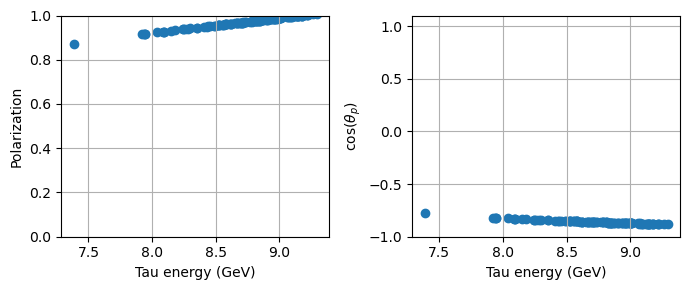

In [49]:
s = np.array(spin_vector(
    tau4m[almost5deg_tau_events], 
    nutau4m[almost5deg_tau_events], 
    nucleon4m[almost5deg_tau_events], 
    "res",
))
# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[almost5deg_tau_events].E, 2*np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1))
axs[1].scatter(tau4m[almost5deg_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs:
    ax.grid()


/tmp/ipykernel_4276/1503412875.py:143: RuntimeWarning: invalid value encountered in sqrt
  return Gamma_Delta_0_res * M_delta_res / W * np.sqrt(lambda_func(W**2, M**2, m_pi**2) / lambda_func(M_delta_res**2, M**2, m_pi**2))


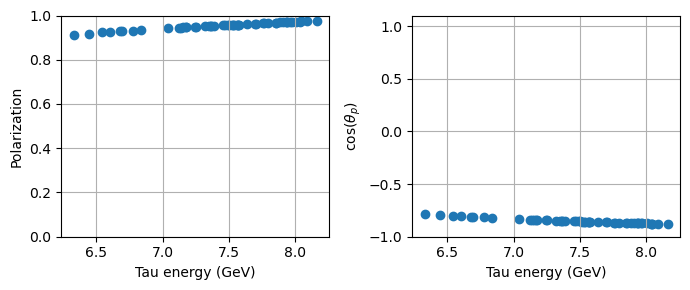

In [50]:
almost10deg_tau_events = np.abs(tau_angles * 180/np.pi - 10) < 0.1
s = np.array(spin_vector(
    tau4m[almost10deg_tau_events], 
    nutau4m[almost10deg_tau_events], 
    nucleon4m[almost10deg_tau_events], 
    "res",
))
# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[almost10deg_tau_events].E, 2*np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1))
axs[1].scatter(tau4m[almost10deg_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs:
    ax.grid()


/tmp/ipykernel_4276/1503412875.py:155: RuntimeWarning: invalid value encountered in sqrt
  W = np.sqrt((p + q)**2)
/tmp/ipykernel_4276/1503412875.py:143: RuntimeWarning: invalid value encountered in sqrt
  return Gamma_Delta_0_res * M_delta_res / W * np.sqrt(lambda_func(W**2, M**2, m_pi**2) / lambda_func(M_delta_res**2, M**2, m_pi**2))
/tmp/ipykernel_4276/3102778512.py:9: RuntimeWarning: invalid value encountered in sqrt
  W = np.sqrt((nucleon4m + q)**2)


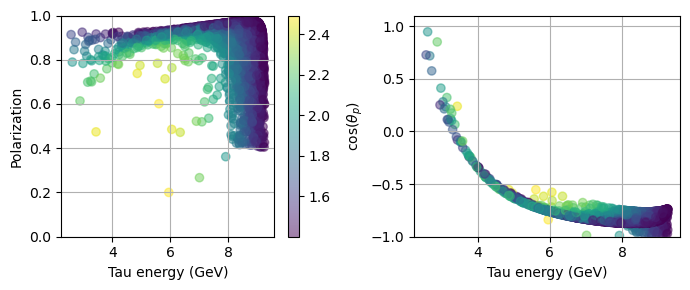

In [51]:
s = np.array(spin_vector(
    tau4m, 
    nutau4m, 
    nucleon4m, 
    "res",
))

q = nutau4m - tau4m
W = np.sqrt((nucleon4m + q)**2)
x = (-q**2 / (2 * nucleon4m.dot(q)))

# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
c = axs[0].scatter(tau4m.E[W > 1.4], 2*np.linalg.norm(s, axis=0)[W > 1.4], c=W[W > 1.4], alpha=0.5)
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1))
fig.colorbar(c, ax=axs[0])
axs[1].scatter(tau4m.E[W > 1.4], (s[1] / np.linalg.norm(s, axis=0))[W > 1.4], c=W[W > 1.4], alpha=0.5)
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs:
    ax.grid()


/tmp/ipykernel_4276/2349854696.py:2: RuntimeWarning: invalid value encountered in sqrt
  W = np.sqrt((nucleon4m + q)**2)#[zero_angle_tau_events]


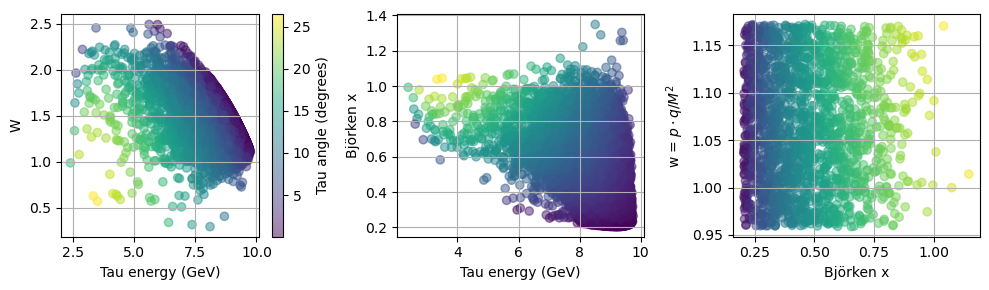

In [52]:
q = nutau4m - tau4m
W = np.sqrt((nucleon4m + q)**2)#[zero_angle_tau_events]
x = (-q**2 / (2 * nucleon4m.dot(q)))#[zero_angle_tau_events]
zeta = nucleon4m.M / M_delta_res
w_value = w(nucleon4m, q, nucleon4m.M)
E_9_events = np.abs(tau4m.E - 9) < 0.1

# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=3, figsize=(10, 3), layout="tight")

c = axs[0].scatter(
    tau4m.E#[zero_angle_tau_events]
    , W, c=180/np.pi * tau_angles#[zero_angle_tau_events]
    , alpha=0.5)
axs[0].set(xlabel="Tau energy (GeV)", ylabel="W")
fig.colorbar(c, ax=axs[0], label="Tau angle (degrees)")

axs[1].scatter(
    tau4m.E#[zero_angle_tau_events]
    , x, c=180/np.pi * tau_angles#[zero_angle_tau_events]
    , alpha=0.5)
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"Björken x")

axs[2].scatter(
    x[E_9_events]
    , w_value[E_9_events]
    , c=180/np.pi * tau_angles[E_9_events]
    , alpha=0.5)
axs[2].set(xlabel="Björken x", ylabel=r"w = $p\cdot q/M^2$")

for ax in axs:
    ax.grid()


/tmp/ipykernel_4276/271128991.py:1: RuntimeWarning: invalid value encountered in sqrt
  W = np.sqrt((nucleon4m + nutau4m - tau4m)**2)


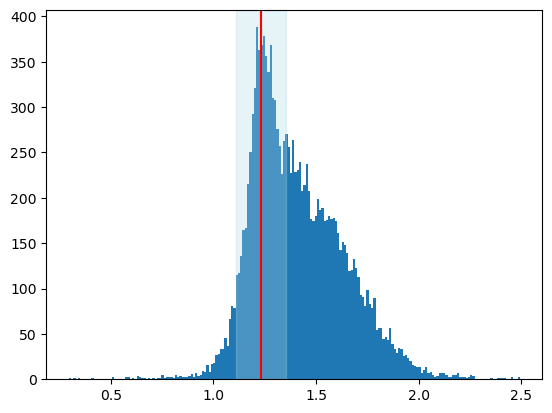

In [53]:
W = np.sqrt((nucleon4m + nutau4m - tau4m)**2)
plt.hist(W, bins=200)
plt.axvline(M_delta_res, color="r")
plt.axvspan(M_delta_res - Gamma_Delta_0_res, M_delta_res + Gamma_Delta_0_res, color="lightblue", alpha=0.3)

In [54]:
wrong_w = ((nucleon4m + nutau4m - tau4m)**2 < 0)
nucleon4m[wrong_w], nutau4m[wrong_w], tau4m[wrong_w]

(MomentumNumpy4D([(0., 0., 0., 0.938919)],
                 dtype=[('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('t', '<f8')]),
 MomentumNumpy4D([(0., 0., 10., 10.)],
                 dtype=[('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('t', '<f8')]),
 MomentumNumpy4D([(1.26898743, 1.00774394, 8.16048799, 8.50743972)],
                 dtype=[('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('t', '<f8')]))

Check how many events have a small angle relative to the neutrino and is a resonance event. The polarization vector of these events do not match the figure in the tau polarization paper. If it is onlt a few number of events, it should not be a big problem.

In [112]:
for e in (5, 10, 20, 50, 100):
    events = pd.read_csv(f"../data/test_genie_NuTau_{e}.0_GeV_event_info.csv")
    taus = pd.read_csv(f"../data/test_genie_NuTau_{e}.0_GeV_particles.csv").query("pdg == 15")
    tau_angles = np.arctan(np.sqrt(taus["px"]**2 + taus["py"]**2) / taus["pz"]) * 180/np.pi
    assert np.all(tau_angles > 0)
    n_bad_events = np.sum((np.abs(tau_angles) < 2) & events["res"])
    print(f"{e} GeV: {n_bad_events} bad events out of {events.shape[0]} events ({n_bad_events / events.shape[0] * 100:.2f}%)")

5 GeV: 138 bad events out of 17881 events (0.77%)
10 GeV: 260 bad events out of 42493 events (0.61%)
20 GeV: 216 bad events out of 56282 events (0.38%)
50 GeV: 112 bad events out of 66363 events (0.17%)
100 GeV: 75 bad events out of 70092 events (0.11%)


## Deep inelastic scattering

In [55]:
# Deep inelastic scattering
# The PDFs used in GENIE seems to bee CT10nlo, member 0 from LHAPDF. Source: https://github.com/GENIE-MC/Generator/blob/master/config/LHAPDF6.xml
# I should therefore probably use the same here
pdfset = lhapdf.mkPDF("CT10nlo", 0)
def pdf(quark, x, Q2):
    # TODO division by x might be wrong. Not sure
    f = pdfset.xfxQ2(quark, x, Q2) / x
    return np.array(f)


def mass_corrected_xi(x, Q2, charm):
    xi = x
    m_charm = 1.27 # GeV
    # If a charm quark is produced, replace x with xi
    xi[charm] = x[charm] / (Q2[charm] / (Q2[charm] + m_charm**2))
    # print(xi)
    return xi

def W1dis(x, Q2, p, q, M, charm):
    xi = mass_corrected_xi(x, Q2, charm)
    return (
        # Correction, see eq. 55 in tau polarization paper. 
        (1 + xi/w(p, q, M)) * 
        np.sum([pdf(quark, xi, Q2) for quark in [*range(1, 7), *range(-6, 0)]], axis=0) # F1
    )

def W2dis(x, Q2, p, q, M, charm):
    xi = mass_corrected_xi(x, Q2, charm)
    return (
        1/w(p, q, M) 
        * 2 * np.sum([xi * pdf(quark, xi, Q2) for quark in [*range(1, 7), *range(-6, 0)]], axis=0) # F2
    )

def W3dis(x, Q2, p, q, M, charm):
    xi = mass_corrected_xi(x, Q2, charm)
    return 1/w(p, q, M) * 2 * (
        np.sum([pdf(quark, xi, Q2) for quark in range(1, 7)], axis=0)
        - np.sum([pdf(quark, xi, Q2) for quark in range(-6, 0)], axis=0)
    )

def W4dis(x, Q2, p, q, M, charm):
    return 0

def W5dis(x, Q2, p, q, M, charm):
    # In the tau polarization paper, there is a factor of 2 in front. 
    xi = mass_corrected_xi(x, Q2, charm)
    
    # I am not sure if this is a mistake, convention difference, or something else
    return 1/w(p, q, M) * 2 * np.sum([pdf(quark, xi, Q2) for quark in [*range(1, 7), *range(-6, 0)]], axis=0) # W1dis(x, Q2, p, q, M, charm) * 


LHAPDF 6.5.4 loading /home/simon/miniconda3/envs/cern-skhep/share/LHAPDF/CT10nlo/CT10nlo_0000.dat
CT10nlo PDF set, member #0, version 4; LHAPDF ID = 11000


In [56]:
dis_particles = particle_info[
    particle_info["event_num"]
    .isin(event_info.loc[event_info["dis"], "event_num"].values)
]
taus = dis_particles[dis_particles["pdg"] == 15]
nutaus = dis_particles.groupby("event_num").nth(1)
assert np.all(nutaus["pdg"] == 16)
nucleons = dis_particles.groupby("event_num").first()
assert np.all(nucleons["pdg"] > 1000)
tau_angles = np.arctan(np.sqrt(taus["px"]**2 + taus["py"]**2) / taus["pz"])

In [57]:
nutau4m = vector.array({"E": nutaus["E"], "px": nutaus["px"], "py": nutaus["py"], "pz": nutaus["pz"]})
tau4m = vector.array({"E": taus["E"], "px": taus["px"], "py": taus["py"], "pz": taus["pz"]})

# If the collision is with a proton, the nucleon mass should be the proton mass
# If not, the nucleon mass should be the Oxygen mass / 16, since there are 16 nucleons in an Oxygen nucleus
nucleon_mass = np.ones(nucleons.shape[0]) * 0.938919 #14.895082 / 16
nucleon_mass[nucleons["pdg"] < 1e5] = nucleons[nucleons["pdg"] < 1e5]["E"]
nucleon4m = vector.array({"E": nucleon_mass, "px": nucleons["px"], "py": nucleons["py"], "pz": nucleons["pz"]})

q = nutau4m - tau4m
# Sanity checks
assert ((q["E"]**2 - q["px"]**2 - q["py"]**2 - q["pz"]**2) < 0).all()
assert np.all((q**2) < 0)

In [58]:
zero_angle_tau_events = (tau_angles * 180/np.pi) < 0.4

s = np.array(polarization_vector(
    tau4m[zero_angle_tau_events], 
    nutau4m[zero_angle_tau_events], 
    nucleon4m[zero_angle_tau_events], 
    "dis",
    charm=(np.zeros(nutau4m[zero_angle_tau_events].shape[0], dtype=bool))
))

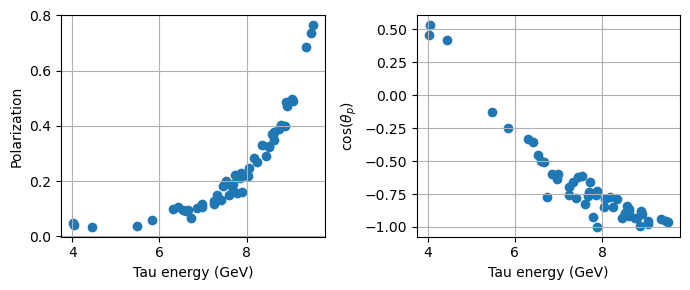

In [59]:
# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[zero_angle_tau_events].E, np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization")
axs[1].scatter(tau4m[zero_angle_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$")

for ax in axs:
    ax.grid()


The value is always within 0 and 1 for the left plot, while it is within -1 and 1 for the right plots, which is good.
However, for the left plot, there should be a dip and a discontinuity at around $E_\tau \approx 9$ GeV, after which the energy increases again. This is not the case here.

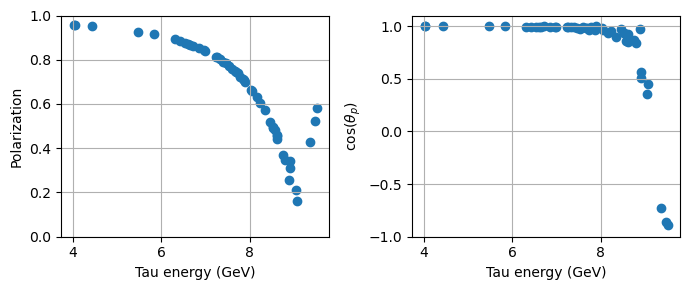

In [60]:
zero_angle_tau_events = (tau_angles * 180/np.pi) < 0.4

s = np.array(spin_vector(
    tau4m[zero_angle_tau_events], 
    nutau4m[zero_angle_tau_events], 
    nucleon4m[zero_angle_tau_events], 
    "dis",
    charm=(np.zeros(nutau4m[zero_angle_tau_events].shape[0], dtype=bool))
))

# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[zero_angle_tau_events].E, 2*np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1))
axs[1].scatter(tau4m[zero_angle_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs:
    ax.grid()


This looks exactly like it should! See tau polarization paper, figure 6, right column

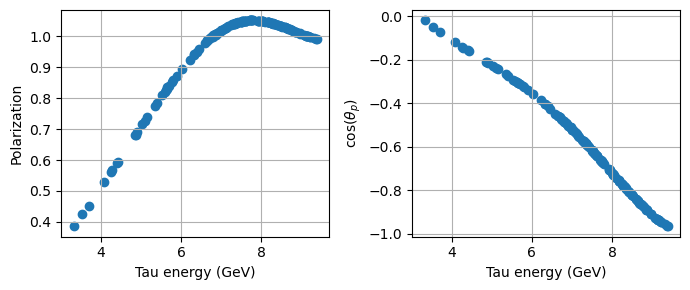

In [61]:
almost5deg_tau_events = np.abs(tau_angles * 180/np.pi - 5) < 0.03
# Drop all x where it is unphysical. This will change later once I have access to W
q = nutau4m - tau4m
x = -q**2 / (2*nucleon4m.dot(q))
almost5deg_tau_events.iloc[x > 1] = False

s = np.array(polarization_vector(
    tau4m[almost5deg_tau_events], 
    nutau4m[almost5deg_tau_events], 
    nucleon4m[almost5deg_tau_events], 
    "dis",
    charm=(np.zeros(nutau4m[almost5deg_tau_events].shape[0], dtype=bool))
))

# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[almost5deg_tau_events].E, np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization")
axs[1].scatter(tau4m[almost5deg_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$")

for ax in axs:
    ax.grid()


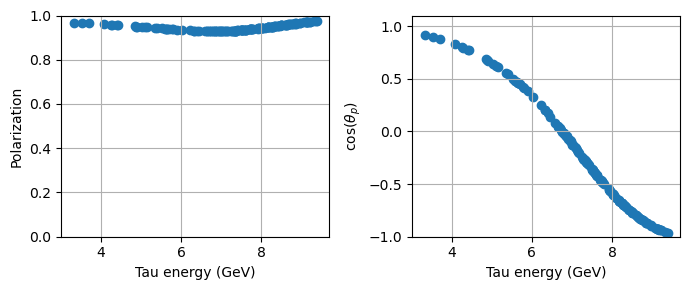

In [62]:
s = np.array(spin_vector(
    tau4m[almost5deg_tau_events], 
    nutau4m[almost5deg_tau_events], 
    nucleon4m[almost5deg_tau_events], 
    "dis",
    charm=(np.zeros(nutau4m[almost5deg_tau_events].shape[0], dtype=bool))
))
# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[almost5deg_tau_events].E, 2*np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1))
axs[1].scatter(tau4m[almost5deg_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs:
    ax.grid()


This looks exactly like Figure 6, center column in the tau polarization paper

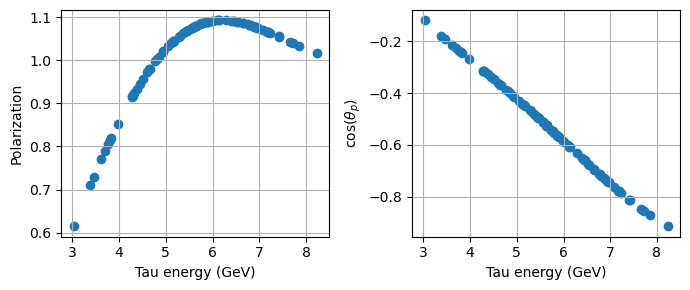

In [63]:
almost10deg_tau_events = np.abs(tau_angles * 180/np.pi - 10) < 0.03
# Drop all x where it is unphysical. This will change later once I have access to W
q = nutau4m - tau4m
x = -q**2 / (2*nucleon4m.dot(q))
almost10deg_tau_events.iloc[x > 1] = False

s = np.array(polarization_vector(
    tau4m[almost10deg_tau_events], 
    nutau4m[almost10deg_tau_events], 
    nucleon4m[almost10deg_tau_events], 
    "dis",
    charm=(np.zeros(nutau4m[almost10deg_tau_events].shape[0], dtype=bool))
))

# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[almost10deg_tau_events].E, np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization")
axs[1].scatter(tau4m[almost10deg_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$")

for ax in axs:
    ax.grid()


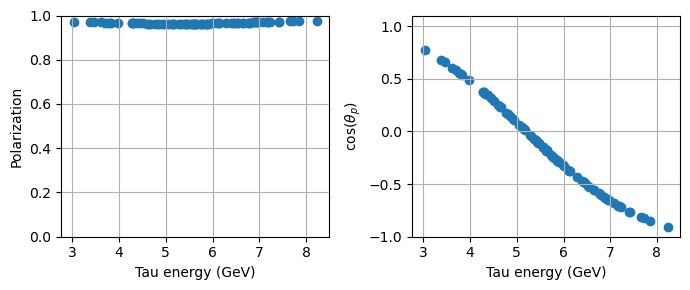

In [64]:
s = np.array(spin_vector(
    tau4m[almost10deg_tau_events], 
    nutau4m[almost10deg_tau_events], 
    nucleon4m[almost10deg_tau_events], 
    "dis",
    charm=(np.zeros(nutau4m[almost10deg_tau_events].shape[0], dtype=bool))
))
# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[almost10deg_tau_events].E, 2*np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1))
axs[1].scatter(tau4m[almost10deg_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs:
    ax.grid()


This plot also looks exactly like it should! See tau polarization paper, figure 6, right column

## Combined plot
Plot all interaction types for the three different angles.

This is a recreation of Figure 6 in the tau polarization paper

NameError: name 'Wnres' is not defined

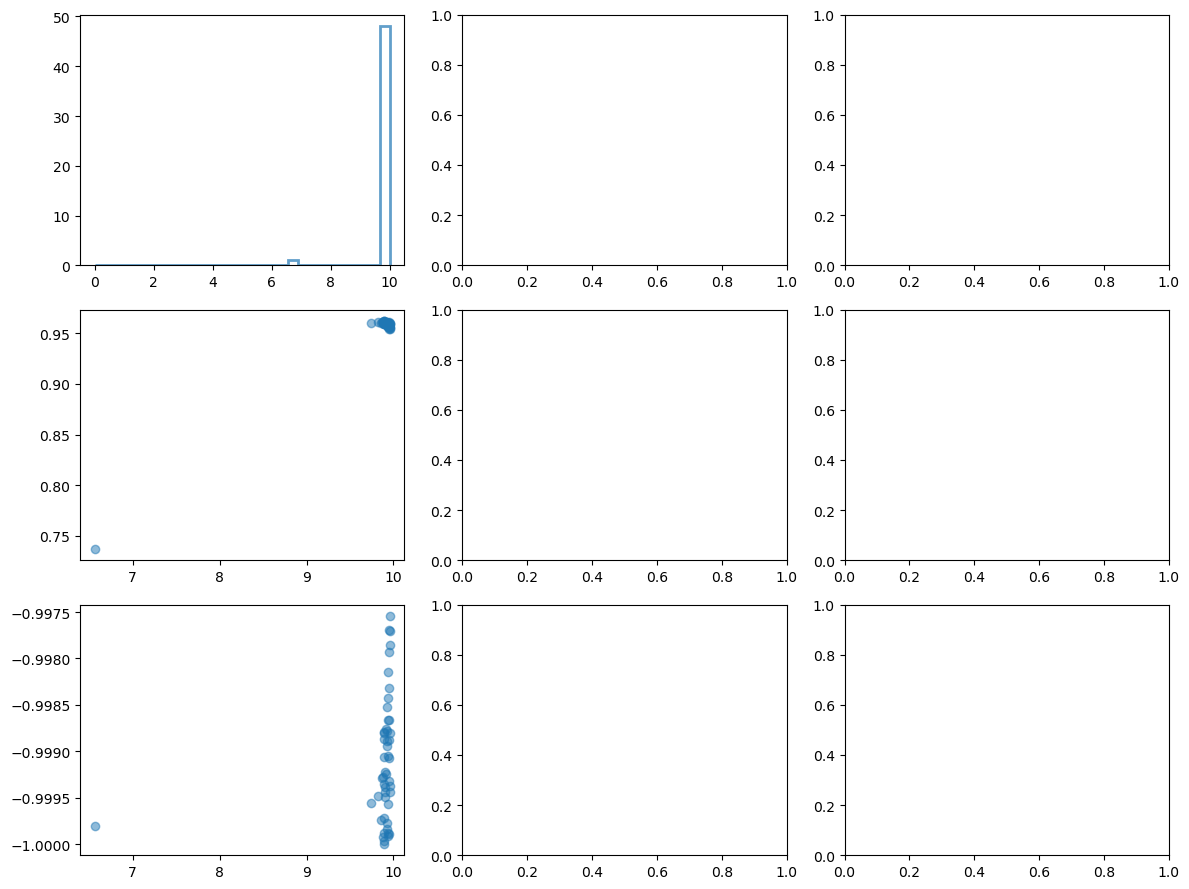

In [9]:
qel_particles = particle_info[
    particle_info["event_num"]
    .isin(event_info.loc[event_info["qel"], "event_num"].values)
]

res_particles = particle_info[
    particle_info["event_num"]
    .isin(event_info.loc[event_info["res"], "event_num"].values)
]

dis_particles = particle_info[
    particle_info["event_num"]
    .isin(event_info.loc[event_info["dis"], "event_num"].values)
]

taus = particle_info[particle_info["pdg"] == 15]
tau_angles = np.arctan(np.sqrt(taus["px"]**2 + taus["py"]**2) / taus["pz"]) * 180/np.pi
assert np.all(tau_angles > 0)
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(12, 9), layout="tight")

for ax_col, angle, angle_limit in zip(axs.T, (0, 5, 10), (0.4, 0.03, 0.1)):
    good_angle_events = taus[np.abs(tau_angles - angle) < angle_limit]

    for particles, int_type in zip((qel_particles, res_particles, dis_particles), ("qel", "res", "dis")):
        selected_events = particles[particles["event_num"].isin(good_angle_events["event_num"])]
        selected_taus = selected_events[selected_events["pdg"] == 15]
        selected_nus = selected_events.groupby("event_num").nth(1)
        tau4m = vector.array({"E": selected_taus["E"], "px": selected_taus["px"], "py": selected_taus["py"], "pz": selected_taus["pz"]})
        nutau4m = vector.array({"E": selected_nus["E"], "px": selected_nus["px"], "py": selected_nus["py"], "pz": selected_nus["pz"]})
        nucleon4m = vector.array({"E": np.ones(selected_nus.shape[0]) * 0.938919, "px": np.zeros(selected_nus.shape[0]), "py": np.zeros(selected_nus.shape[0]), "pz": np.zeros(selected_nus.shape[0])})

        q = nutau4m - tau4m

        x = (-q**2 / (2 * nucleon4m.dot(q)))
        tau4m = tau4m[x <= 1]
        nutau4m = nutau4m[x <= 1]
        nucleon4m = nucleon4m[x <= 1]

        s = np.array(spin_vector(
            tau4m, 
            nutau4m,
            nucleon4m,
            int_type,
            np.zeros(len(tau4m), dtype=bool)
        ))

        ax_col[0].hist(tau4m.E, bins=np.linspace(0, 10, 30), histtype="step", label=int_type, lw=2, alpha=0.7)
        ax_col[1].scatter(tau4m.E, 2 * np.linalg.norm(s, axis=0), label=int_type, alpha=0.5)
        ax_col[2].scatter(tau4m.E, s[1] / np.linalg.norm(s, axis=0), label=int_type, alpha=0.5)
    
    ax_col[0].set(xlim=(2, 10.5), xlabel="Tau energy (GeV)", ylabel="Counts (arbitrary units)")
    ax_col[1].set(xlim=(2, 10.5), xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1.1))
    ax_col[2].set(xlim=(2, 10.5), xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs.flat:
    ax.grid()
    ax.legend()

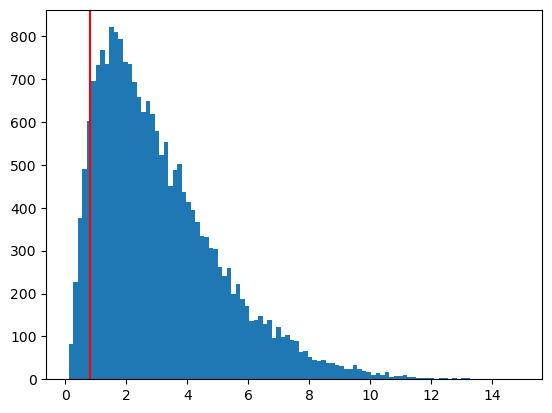

In [12]:

taus = dis_particles[dis_particles["pdg"] == 15]

nus = dis_particles.groupby("event_num").nth(1)
tau4m = vector.array({"E": taus["E"], "px": taus["px"], "py": taus["py"], "pz": taus["pz"]})
nutau4m = vector.array({"E": nus["E"], "px": nus["px"], "py": nus["py"], "pz": nus["pz"]})
nucleon4m = vector.array({"E": np.ones(nus.shape[0]) * 0.938919, "px": np.zeros(nus.shape[0]), "py": np.zeros(nus.shape[0]), "pz": np.zeros(nus.shape[0])})

q = nutau4m - tau4m
Q2 = -q**2
plt.hist(Q2, bins=100)
plt.axvline(0.8, c="r")

In [15]:
np.sum(Q2 < 0.8) / len(Q2)

0.07229028336294772

## Change all polarization vectors for IceCube events

In [ ]:
neutrino_energies = (5, 10, 20, 50, 100)
for e in neutrino_energies:
    # Load files
    particle_info = pd.read_csv(f"../data/test_genie_NuTau_{e}_GeV_particles.csv")
    event_info = pd.read_csv(f"../data/test_genie_NuTau_{e}_GeV_event_info.csv")
    # Select qel, res and dis particles
    qel_particles = particle_info[
        particle_info["event_num"]
        .isin(event_info.loc[event_info["qel"], "event_num"].values)
    ]

    res_particles = particle_info[
        particle_info["event_num"]
        .isin(event_info.loc[event_info["res"], "event_num"].values)
    ]

    dis_particles = particle_info[
        particle_info["event_num"]
        .isin(event_info.loc[event_info["dis"], "event_num"].values)
    ]
    
    for ax_col, angle, angle_limit in zip(axs.T, (0, 5, 10), (0.4, 0.03, 0.1)):

        for particles, int_type in zip((qel_particles, res_particles, dis_particles), ("qel", "res", "dis")):

            selected_taus = particles[particles["pdg"] == 15]
            selected_nus = particles.groupby("event_num").nth(1)

            tau4m = vector.array({"E": selected_taus["E"], "px": selected_taus["px"], "py": selected_taus["py"], "pz": selected_taus["pz"]})
            nutau4m = vector.array({"E": selected_nus["E"], "px": selected_nus["px"], "py": selected_nus["py"], "pz": selected_nus["pz"]})
            nucleon4m = vector.array({"E": np.ones(selected_nus.shape[0]) * 0.938919, "px": np.zeros(selected_nus.shape[0]), "py": np.zeros(selected_nus.shape[0]), "pz": np.zeros(selected_nus.shape[0])})

            # TODO I should not have to do this. Instead, use Ws to calculate nucleon mass perhaps? Compare this nucleon mass to the one calculated with W
            # q = nutau4m - tau4m
            # x = (-q**2 / (2 * nucleon4m.dot(q)))
            # tau4m = tau4m[x <= 1]
            # nutau4m = nutau4m[x <= 1]
            # nucleon4m = nucleon4m[x <= 1]

            s = np.array(spin_vector(
                tau4m, 
                nutau4m,
                nucleon4m,
                int_type,
                np.zeros(len(tau4m), dtype=bool)
            ))

            ax_col[0].hist(tau4m.E, bins=np.linspace(0, 10, 30), histtype="step", label=int_type, lw=2, alpha=0.7)
            ax_col[1].scatter(tau4m.E, 2 * np.linalg.norm(s, axis=0), label=int_type, alpha=0.5)
            ax_col[2].scatter(tau4m.E, s[1] / np.linalg.norm(s, axis=0), label=int_type, alpha=0.5)

    # For other interactions, we assume unpolarized (or fully left-handed is a better approximation perhaps?)

## Load my own GENIE events
For testing and evaluating W and Q2 values, I will use my own GENIE events.

In [3]:
import uproot

with uproot.open("../data/gntp.0.gst.root") as f:
    tree = f["gst"]
    qel = tree["qel"].array()
    res = tree["res"].array()
    dis = tree["dis"].array()
    cc = tree["cc"].array()
    taus = vector.array({"E": tree["El"].array(), "px": tree["pxl"].array(), "py": tree["pyl"].array(), "pz": tree["pzl"].array()})
    Q2 = tree["Q2s"].array()
    W = tree["Ws"].array()
    Ev = tree["Ev"].array()
    charm = tree["charm"].array()
    resid = tree["resid"].array()

nutaus = vector.array({"E": Ev, "px": np.zeros(len(Ev)), "py": np.zeros(len(Ev)), "pz": Ev})

In [70]:
q = nutaus - taus
M = -q.E + np.sqrt(W**2 + q.px**2 + q.py**2 + q.pz**2)

In [71]:
pd.Series(M[cc]).value_counts()

0.938272    252
1.877837    184
1.877837    174
1.877837    171
1.877837    168
           ... 
0.943217      1
0.824858      1
0.849733      1
0.894963      1
0.990134      1
Name: count, Length: 15984, dtype: int64

In [72]:
(Q2 / (2*q.E))[qel & cc]

<Array [0.836, 1.44, 1.05, ..., 0.986, 0.842, 1.29] type='3133 * float64'>

In [152]:
atan_angle = np.arctan(np.sqrt(taus.px **2 + taus.py**2) / taus.pz)
deltaangle = nutaus.deltaangle(taus)
assert np.allclose(np.arctan2(np.sqrt(taus.px**2 + taus.py**2), taus.pz), nutaus.deltaangle(taus))

vec2d = vector.array({"x": taus.pz, "y": np.sqrt(taus.px**2 + taus.py**2)})
assert np.allclose(vec2d.phi, deltaangle)

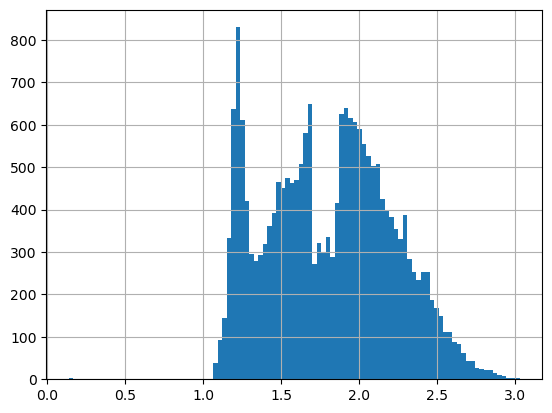

In [73]:
# W2 = (M + q.E)**2 - q.px**2 - q.py**2 - q.pz**2
plt.hist(W[cc], bins=100)
plt.grid()

In [74]:
np.sum(W > 2) / len(W)

0.50026

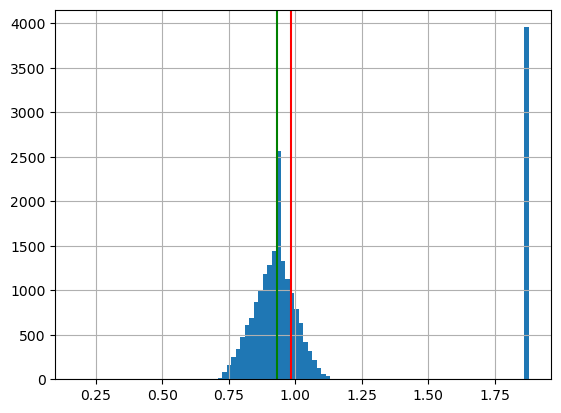

In [75]:
plt.hist(M[cc], bins=100)
plt.grid()
plt.axvline(0.983, c="r")
plt.axvline(14.895082 / 16, c="g")

In [77]:
np.sum(Q2 < 0)

12

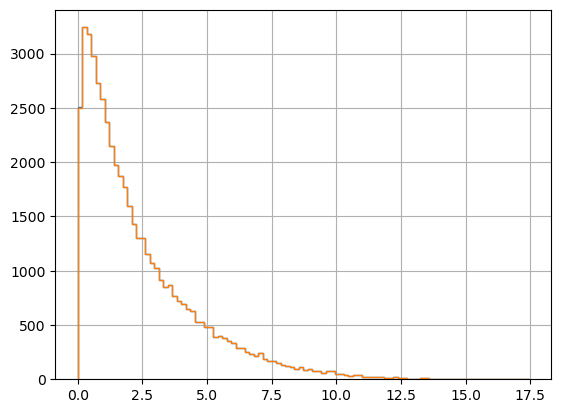

In [81]:
q2 = np.array(Q2)
q2[q2 < 0] = np.nan
plt.hist(-q**2, bins=100, histtype="step")
plt.hist(q2, bins=100, histtype="step")
plt.grid()

Q2s, Q2 and `-q**2` follow each other perfectly. This is a good cross-check. This means that I can safely use `-q**2` everywhere. 

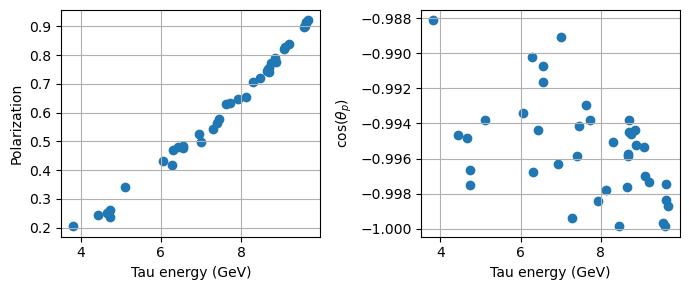

In [55]:
# If the collision is with a proton, the nucleon mass should be the proton mass
# If not, the nucleon mass should be the Oxygen mass / 16, since there are 16 nucleons in an Oxygen nucleus
nucleon4m = vector.array({"E": M, "px": np.zeros(len(M)), "py": np.zeros(len(M)), "pz": np.zeros(len(M))})
nutau4m = nutaus
tau4m = taus

q = nutau4m - tau4m
# Sanity checks
assert np.all((q**2) < 0)

tau_angles = np.arctan(np.sqrt(tau4m.px**2 + tau4m.py**2) / tau4m.pz)

zero_angle_tau_events = dis & cc & ((tau_angles * 180/np.pi) < 0.5)

s = np.array(polarization_vector(
    tau4m[zero_angle_tau_events], 
    nutau4m[zero_angle_tau_events], 
    nucleon4m[zero_angle_tau_events], 
    "dis",
    charm=(np.zeros(nutau4m[zero_angle_tau_events].shape[0], dtype=bool))
))
# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[zero_angle_tau_events].E, np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization")
axs[1].scatter(tau4m[zero_angle_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$")

for ax in axs:
    ax.grid()


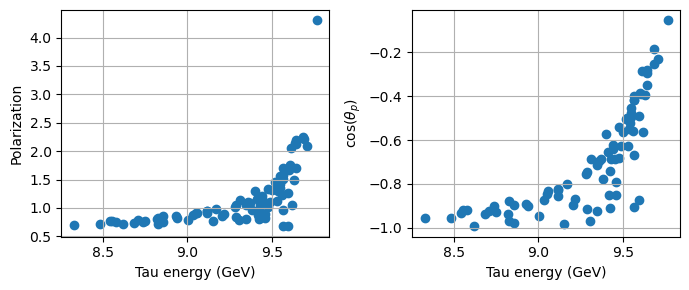

In [94]:
# If the collision is with a proton, the nucleon mass should be the proton mass
# If not, the nucleon mass should be the Oxygen mass / 16, since there are 16 nucleons in an Oxygen nucleus
nucleon4m = vector.array({"E": M, "px": np.zeros(len(M)), "py": np.zeros(len(M)), "pz": np.zeros(len(M))})
nutau4m = nutaus
tau4m = taus

q = nutau4m - tau4m
# Sanity checks
assert np.all((q**2) < 0)

tau_angles = np.arctan(np.sqrt(tau4m.px**2 + tau4m.py**2) / tau4m.pz)

zero_angle_tau_events = res & cc & ((tau_angles * 180/np.pi) < 1)

s = np.array(polarization_vector(
    tau4m[zero_angle_tau_events], 
    nutau4m[zero_angle_tau_events], 
    nucleon4m[zero_angle_tau_events], 
    "res",
    charm=(np.zeros(nutau4m[zero_angle_tau_events].shape[0], dtype=bool))
))
# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[zero_angle_tau_events].E, np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization")
axs[1].scatter(tau4m[zero_angle_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$")

for ax in axs:
    ax.grid()


This plot looks just as weird. It is likely something wrong with the code.